**Problem**: Given a phishing url, classify the domain as compromised (owned) or malicious (hacked).

**Objective**: Given labeled data, analyze the best model and features.

In [1]:
import sklearn
print(sklearn.__version__)

0.20.1


# Setup

In [1]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

#from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import xgboost as xgb

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import scipy

from pprint import pprint

import pickle

import numpy as np
from numpy import nan

# Data

In [2]:
# balanced train and test sets
def balance_data(X, y):
    X_bal = []
    y_bal = []
    X_rest = []
    y_rest = []
    min1 = len([tar for tar in y if tar==1])
    min2 = len([tar for tar in y if tar==0])
    mini = min1
    if min2 < min1:
        mini = min2

    cnt_1 = 0
    cnt_0 = 0
    print(mini)
    for i, tar in enumerate(y):
        if tar == 1 and cnt_1<mini:
            cnt_1+=1
            X_bal.append(X[i])
            y_bal.append(y[i])
        elif tar == 0 and cnt_0<mini:
            cnt_0+=1
            X_bal.append(X[i])
            y_bal.append(y[i])
        else:
            X_rest.append(X[i])
            y_rest.append(y[i])

    print("# X_bal:", len(X_bal))
    print("# y_bal:", len(y_bal))
    print("% compromised: ", len([tar for tar in y_bal if tar==1])/len(y_bal))
    print("% malicious: ", len([tar for tar in y_bal if tar==0])/len(y_bal))
    
    print("# X_bal:", len(X_rest))
    print("# y_bal:", len(y_rest))
    print("% compromised: ", len([tar for tar in y_rest if tar==1])/len(y_rest))
    print("% malicious: ", len([tar for tar in y_rest if tar==0])/len(y_rest))
    
    return [X_bal, y_bal, X_rest, y_rest]

### Train/Test

In [3]:
with open("data/data_cluster_26977", "r", encoding='utf-8') as f:
    data_train = eval(f.read())

Xtrain = np.array([d['feat'] for d in data_train])
ytrain = np.array([d['target'] for d in data_train])
feat_labels = data_train[0]['feat_labels']
print(Xtrain.shape)
print(ytrain.shape)
print(feat_labels)
pprint(Xtrain[:5])
pprint(ytrain[:5])
print("# compromised: ", len([tar for tar in ytrain if tar==1]))
print("# malicious: ", len([tar for tar in ytrain if tar==0]))
print("% compromised: ", len([tar for tar in ytrain if tar==1])/len(ytrain))
print("% malicious: ", len([tar for tar in ytrain if tar==0])/len(ytrain))

(26977, 19)
(26977,)
['archived', 'years_active', 'years_inactive', 'num_captures', 'freenom_tld', 'prev_mal_tld', 'wildcard_subdomain', 'reachable', 'redirected', 'blocked', 'alexa_rank', 'ratio_longest_word', 'contain_digit', 'contain_dash', 'name_len', 'brandname_partialratio', 'prev_mal_domain_ed', 'sub_levels', 'num_sub']
array([[1.00000000e+00, 9.00000000e+00, 1.00000000e+00, 7.42000000e+02,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.14676000e+05, 3.75000000e-01,
        1.00000000e+00, 0.00000000e+00, 4.00000000e+00, 6.70000000e+01,
        2.50000000e-01, 3.00000000e+00, 8.00000000e+00],
       [0.00000000e+00,            nan,            nan,            nan,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                   nan,            nan,            nan, 2.00000000e-01,
        1.00000000e+00, 0.00000000e+00, 7.00000000e+00, 6.70000000e+01,
        1.42857143e-01, 2.00000000e+00

In [4]:
# balance
Xtrain, ytrain, Xtest, ytest = balance_data(Xtrain, ytrain)

7636
# X_bal: 15272
# y_bal: 15272
% compromised:  0.5
% malicious:  0.5
# X_bal: 11705
# y_bal: 11705
% compromised:  1.0
% malicious:  0.0


### Predict

#### Comp

In [31]:
with open("data/test_comp_689", "r", encoding='utf-8') as f:
    data_predict = eval(f.read())

Xpredict = np.array([d['feat'] for d in data_predict])
ypredict = np.array([d['target'] for d in data_predict])
feat_labels = data_predict[0]['feat_labels']
print(Xpredict.shape)
print(ypredict.shape)
print(feat_labels)
pprint(Xpredict[:5])
pprint(ypredict[:5])
print("# compromised: ", len([tar for tar in ypredict if tar==1]))
print("# malicious: ", len([tar for tar in ypredict if tar==0]))
print("% compromised: ", len([tar for tar in ypredict if tar==1])/len(ypredict))
print("% malicious: ", len([tar for tar in ypredict if tar==0])/len(ypredict))

(689, 19)
(689,)
['archived', 'years_active', 'years_inactive', 'num_captures', 'freenom_tld', 'prev_mal_tld', 'wildcard_subdomain', 'reachable', 'redirected', 'blocked', 'alexa_rank', 'ratio_longest_word', 'contain_digit', 'contain_dash', 'name_len', 'brandname_partialratio', 'prev_mal_domain_ed', 'sub_levels', 'num_sub']
array([[1.00000000e+00, 6.00000000e+00, 0.00000000e+00, 7.40000000e+01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00,            nan, 3.33333333e-01,
        1.00000000e+00, 0.00000000e+00, 5.00000000e+00, 6.00000000e+01,
        2.00000000e-01, 3.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 8.00000000e+00, 1.00000000e+00, 9.50000000e+01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00,            nan, 6.66666667e-01,
        1.00000000e+00, 0.00000000e+00, 9.00000000e+00, 6.70000000e+01,
        1.11111111e-01, 3.00000000e+00, 1.

#### Mal

In [35]:
with open("data/test_mal_2806", "r", encoding='utf-8') as f:
    data_predict = eval(f.read())

Xpredict = np.array([d['feat'] for d in data_predict])
ypredict = np.array([d['target'] for d in data_predict])
feat_labels = data_predict[0]['feat_labels']
print(Xpredict.shape)
print(ypredict.shape)
print(feat_labels)
pprint(Xpredict[:5])
pprint(ypredict[:5])
print("# compromised: ", len([tar for tar in ypredict if tar==1]))
print("# malicious: ", len([tar for tar in ypredict if tar==0]))
print("% compromised: ", len([tar for tar in ypredict if tar==1])/len(ypredict))
print("% malicious: ", len([tar for tar in ypredict if tar==0])/len(ypredict))

(2806, 19)
(2806,)
['archived', 'years_active', 'years_inactive', 'num_captures', 'freenom_tld', 'prev_mal_tld', 'wildcard_subdomain', 'reachable', 'redirected', 'blocked', 'alexa_rank', 'ratio_longest_word', 'contain_digit', 'contain_dash', 'name_len', 'brandname_partialratio', 'prev_mal_domain_ed', 'sub_levels', 'num_sub']
array([[0.00000000e+00,            nan,            nan,            nan,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                   nan,            nan,            nan, 2.35294118e-01,
        1.00000000e+00, 1.00000000e+00, 1.30000000e+01, 5.50000000e+01,
        7.69230769e-02, 2.00000000e+00, 2.00000000e+00],
       [0.00000000e+00,            nan,            nan,            nan,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                   nan,            nan,            nan, 6.25000000e-02,
        1.00000000e+00, 0.00000000e+00, 1.30000000e+01, 5.00000000e+01,
        7.69230769e-02, 7.00000000e+00, 

In [27]:
with open("data/test_post_mal_324", "r", encoding='utf-8') as f:
    data_predict = eval(f.read())

Xpredict = np.array([d['feat'] for d in data_predict])
ypredict = np.array([d['target'] for d in data_predict])
feat_labels = data_predict[0]['feat_labels']
print(Xpredict.shape)
print(ypredict.shape)
print(feat_labels)
pprint(Xpredict[:5])
pprint(ypredict[:5])
print("# compromised: ", len([tar for tar in ypredict if tar==1]))
print("# malicious: ", len([tar for tar in ypredict if tar==0]))
print("% compromised: ", len([tar for tar in ypredict if tar==1])/len(ypredict))
print("% malicious: ", len([tar for tar in ypredict if tar==0])/len(ypredict))

(324, 19)
(324,)
['archived', 'years_active', 'years_inactive', 'num_captures', 'freenom_tld', 'prev_mal_tld', 'wildcard_subdomain', 'reachable', 'redirected', 'blocked', 'alexa_rank', 'ratio_longest_word', 'contain_digit', 'contain_dash', 'name_len', 'brandname_partialratio', 'prev_mal_domain_ed', 'sub_levels', 'num_sub']
array([[  1.        ,  16.        ,   1.        ,  83.        ,
          0.        ,   0.        ,   0.        ,   1.        ,
          1.        ,   0.        ,          nan,   0.21428571,
          1.        ,   0.        ,  10.        ,  80.        ,
          0.        ,   3.        ,  92.        ],
       [  1.        ,   1.        ,   1.        ,  58.        ,
          0.        ,   0.        ,   0.        ,   1.        ,
          1.        ,   0.        ,          nan,   0.5       ,
          0.        ,   0.        ,   6.        ,  67.        ,
          0.16666667,   2.        ,   1.        ],
       [  0.        ,          nan,          nan,          na

# Normalize and imputer

In [5]:
imp = Imputer(missing_values=np.nan, strategy='mean')
imp.fit(Xtrain)
Xtrain = imp.transform(Xtrain)
Xtest = imp.transform(Xtest)

scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)
print(Xtrain[2])
print(Xtest[2])

[ 1.33252125  2.60730598 -1.34740656 -0.07073816 -0.35986422 -0.41133086
  2.57308346  1.07680187 -0.64690462 -0.29947909  5.18159458 -1.13234227
  2.81712975 -0.40817032 -1.03030801 -1.51748492  0.93104907 -0.46694308
 -0.04200788]
[ 1.33252125e+00  2.60730598e+00  7.55458363e-02 -4.11104417e-02
 -3.59864218e-01 -4.11330863e-01 -3.88638774e-01  1.07680187e+00
 -6.46904617e-01 -2.99479086e-01  1.58602495e-12 -4.75707797e-01
 -3.54971226e-01 -4.08170319e-01 -8.60625119e-01 -5.32152024e-01
  5.73363397e-01 -4.66943080e-01 -4.20078769e-02]


C:\Users\Sophie\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


# Visualize data with t-SNE

Takes a high dimensional dataset and reduces to a low dimensional graph that retains a lot of the original information.

What t-SNE does is find a way to project data into a low dimensional space so that the clustering in the high dimensional space is preserved.

O(n^2) time and memory. 

In [7]:
def plottsne(data, ax, title=None):
    X_embedded = data[0]
    y = data[1]
    sc = ax.scatter(X_embedded[:, 0], X_embedded[:, 1],
                c=y, marker='o', alpha=.3)
    #plt.colorbar(sc)
    if title:
        ax.set_title(title)
    return sc

In [8]:
def plotsidebyside(tr, te, title1=None, title2=None):
    # display images
    fig, ax = plt.subplots(1,2)
    #fig.set_size_inches(18.5, 10.5)
    fig.set_size_inches(15, 7)
    
    if tr:
        sc_tr = plottsne(tr, ax[0], title1)
    if te:
        sc_te = plottsne(te, ax[1], title2)
    
    #plt.figure(figsize=(15, 15))
    print("blue malicious (owned), yellow compromised (hacked)")

In [9]:
Xtrain_embedded = TSNE(n_components=2, perplexity=40, verbose=0).fit_transform(Xtrain)

blue malicious (owned), yellow compromised (hacked)


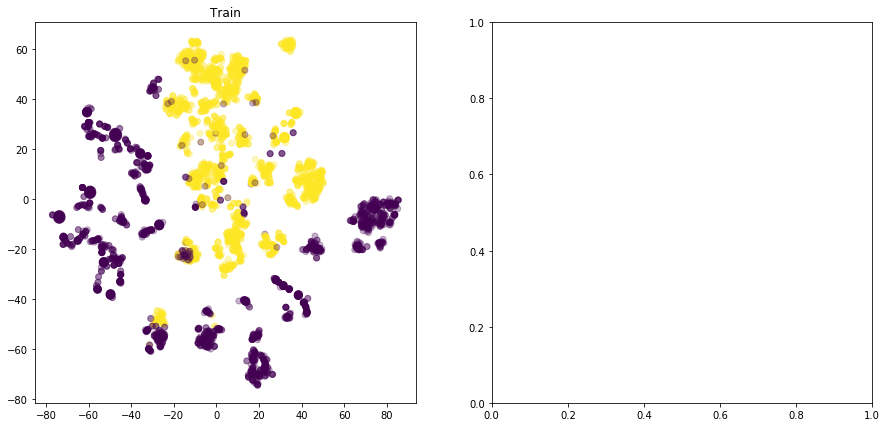

In [10]:
plotsidebyside([Xtrain_embedded, ytrain], None, title1="Train", title2="Test")

# ROC
Compare the performance of each model.

In [6]:
names = [
        #"KNeighbors", 
         #"Linear SVM", 
         #"RBF SVM", 
         "Neural Net", 
        "Random Forest",
         #"QDA",
         #"SGDClassifier",
         "GaussianNB",
         "XGBoost"
        ]

classifiers = [
    #KNeighborsClassifier(),
    #SVC(kernel="linear", C=0.025, probability=True),
    #SVC(kernel="linear", probability=True, class_weight={'balanced'}),
    #SVC(kernel="linear", probability=True, class_weight='balanced'),
    #SVC(gamma=2, probability=True),
    #RandomForestClassifier(random_state=42),
    #RandomForestClassifier(n_estimators=10, max_features=1, random_state=42),
    MLPClassifier(random_state=42),
    RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1, random_state=42),
    #QuadraticDiscriminantAnalysis(),
    #SGDClassifier(max_iter=1000, probability=True),
    GaussianNB(),
    GradientBoostingClassifier()
]

In [7]:
def plot_roc_curve(fpr, tpr, ax, axins, name, label=None):
    #plt.xlim(0, 0.2)
    #plt.ylim(0.6, 1)
    #ax.plot(fpr, tpr, 'r', linewidth=2, label=label)
    ax.plot(fpr, tpr, linewidth=2, label=label)
    ax.grid()
    if axins and name == 'Random Forest':
        axins.plot(fpr, tpr, 'r', linewidth=2)
        axins.grid()
        axins.set_xticks(ticks=[0,5,10,15,20])
        axins.set_yticks(ticks=[60,70,80,90,100])

In [8]:
def getRoc(data, title=None):
    X, y = data
    y = y
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    axins = inset_axes(ax, width=2, height=1.5, loc=10)
    #axins = inset_axes(ax)

    #plt.figure(figsize=(8, 6))
    #ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('False Postive Rate (%)')
    ax.set_ylabel('True Positive Rate (%)')
    ax.axis([0, 100, 0, 100])
    ax.set_xticks(ticks=[0,10,20,30,40,50,60,70,80,90,100])
    ax.set_yticks(ticks=[0,10,20,30,40,50,60,70,80,90,100])
    
    #axins.set_xlim([0, 0.5])
    #axins.set_ylim([0.6, 1])
    axins.axis([0, 20, 60, 100])
    #plt.axis([0, 1, 0, 1])
    #plt.xlabel('False Positive Rate', fontsize=16)
    #plt.ylabel('True Positive Rate', fontsize=16)

    for name, clf in zip(names, classifiers):
        y_scores = cross_val_predict(clf, X, y, cv=10, method="predict_proba")
        fpr, tpr, thresholds = roc_curve(y, y_scores[:, 1])
        fpr, tpr = fpr*100, tpr*100
        roc_auc = auc(fpr, tpr)/(100*100)
        plot_roc_curve(fpr, tpr, ax, axins, name, label='%s (AUC = %0.3f)' % (name, roc_auc))

    ax.legend()
    #plt.show()

C:\Users\Sophie\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Sophie\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Sophie\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Sophie\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

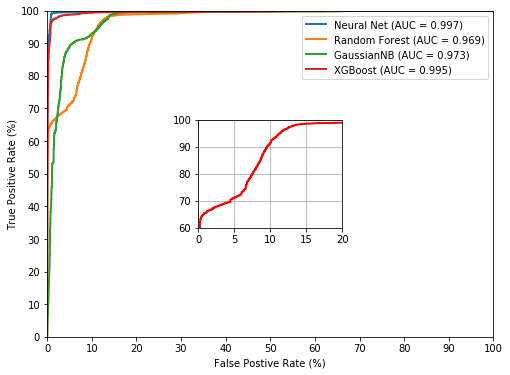

In [9]:
getRoc([Xtrain, ytrain])

In [10]:
clf = classifiers[1]
name = names[1]
model = clf.fit(Xtrain, ytrain)

#threshold = 0.67
threshold = 0.5
#threshold = 0.33

predicted = model.predict(Xtest)

tn, fp, fn, tp = confusion_matrix(ytest, predicted, labels=[0,1]).ravel()
print(np.array([[tp, fp],[fn, tn]]))
print("acc: ", accuracy_score(ytest, predicted))
print("tpr: ", tp/(tp+fn))
print("fpr: ", fp/(tn+fp))
#print("f1: ", f1_score(ytrain, predicted, average='micro'))
print("f1: ", f1_score(ytest, predicted))

[[9786    0]
 [1919    0]]
acc:  0.836052968816745
tpr:  0.836052968816745
fpr:  nan
f1:  0.9107068075008142


C:\Users\Sophie\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  from ipykernel import kernelapp as app


# Classifier predictions

In [11]:
clf = classifiers[3]
name = names[3]
model = clf.fit(Xtrain, ytrain)

#threshold = 0.67
threshold = 0.5
#threshold = 0.33

predicted_proba = model.predict_proba(Xtest)
predicted = (predicted_proba [:,1] >= threshold).astype('int')
predicted = clf.predict(Xtest)

tn, fp, fn, tp = confusion_matrix(ytest, predicted, labels=[0,1]).ravel()
print(np.array([[tp, fp],[fn, tn]]))
print("acc: ", accuracy_score(ytest, predicted))
print("tpr: ", tp/(tp+fn))
print("fpr: ", fp/(tn+fp))
print("fnr: ", fn/(tp+fn))
print("tnr: ", tn/(tn+fp))
print("f1: ", f1_score(ytest, predicted, average='micro'))

[[11330     0]
 [  375     0]]
acc:  0.9679624092268262
tpr:  0.9679624092268262
fpr:  nan
fnr:  0.032037590773173856
tnr:  nan
f1:  0.9679624092268262


C:\Users\Sophie\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\Sophie\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in longlong_scalars


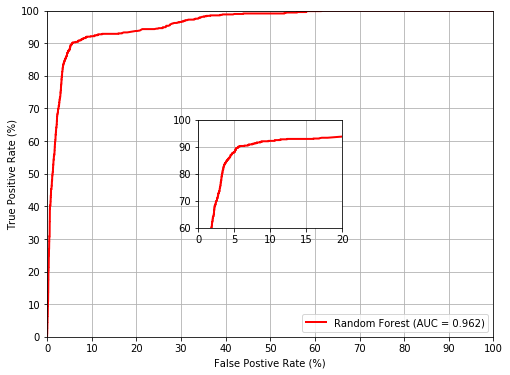

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
axins = inset_axes(ax, width=2, height=1.5, loc=10)
#axins = inset_axes(ax)

#plt.figure(figsize=(8, 6))
#ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Postive Rate (%)')
ax.set_ylabel('True Positive Rate (%)')
ax.axis([0, 100, 0, 100])
ax.set_xticks(ticks=[0,10,20,30,40,50,60,70,80,90,100])
ax.set_yticks(ticks=[0,10,20,30,40,50,60,70,80,90,100])

#axins.set_xlim([0, 0.5])
#axins.set_ylim([0.6, 1])
axins.axis([0, 20, 60, 100])
fpr, tpr, thresholds = roc_curve(ytest, predicted_proba[:, 1])
fpr, tpr = fpr*100, tpr*100
roc_auc = auc(fpr, tpr)/(100*100)
plot_roc_curve(fpr, tpr, ax, axins, name, label='%s (AUC = %0.3f)' % (name, roc_auc))

ax.legend(loc='lower right')

# Features

In [12]:
def getAUC(X, y, feat=""):
    y_scores = cross_val_predict(clf, X, y, cv=5, method="predict_proba")
    fpr, tpr, thresholds = roc_curve(y, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)
    #print("%s: AUC %s" % (feat, roc_auc))
    #print()
    return roc_auc, feat

#### Individual

In [13]:
auc_feat_list = []
print(feat_labels)
paper_feat_labels = feat_labels
#paper_feat_labels = ["Archived", "Years active", "Years inactive", "Number of captures", "Archive redirected", "Freenom TLD", "Wildcard subdomain", "Reachable", "Blocked", "Alexa rank", "Ratio of longest word", "Contain digits", "Contain hyphen", "Name length", "Match brand name"]
for i, feat in enumerate(paper_feat_labels):
    if 'excluded' in feat:
        continue
    X = Xtrain[:,i].reshape(-1, 1)
    auc_feat_list.append(getAUC(X, ytrain, feat))

ftld = auc_feat_list[5]
auc_feat_list[5] = auc_feat_list[7]

wcsd = auc_feat_list[6]
auc_feat_list[6] = auc_feat_list[8]

auc_feat_list[7] = wcsd
auc_feat_list[8] = auc_feat_list[9]
auc_feat_list[9] = ftld
pprint(auc_feat_list)

['archived', 'years_active', 'years_inactive', 'num_captures', 'freenom_tld', 'prev_mal_tld', 'wildcard_subdomain', 'reachable', 'redirected', 'blocked', 'alexa_rank', 'ratio_longest_word', 'contain_digit', 'contain_dash', 'name_len', 'brandname_partialratio', 'prev_mal_domain_ed', 'sub_levels', 'num_sub']
[(0.7557684046592454, 'archived'),
 (0.7585710322557454, 'years_active'),
 (0.7597260440399629, 'years_inactive'),
 (0.7596481308658688, 'num_captures'),
 (0.5487257208623594, 'freenom_tld'),
 (0.6685958166370816, 'reachable'),
 (0.7634453991061612, 'redirected'),
 (0.5532856995659775, 'wildcard_subdomain'),
 (0.6739431677332237, 'blocked'),
 (0.6300165330966521, 'prev_mal_tld'),
 (0.5135195306701102, 'alexa_rank'),
 (0.5875222540468202, 'ratio_longest_word'),
 (0.5335854401046463, 'contain_digit'),
 (0.5875616822632503, 'contain_dash'),
 (0.6297185319271484, 'name_len'),
 (0.5342620567678509, 'brandname_partialratio'),
 (0.6294519755748802, 'prev_mal_domain_ed'),
 (0.577752357049305

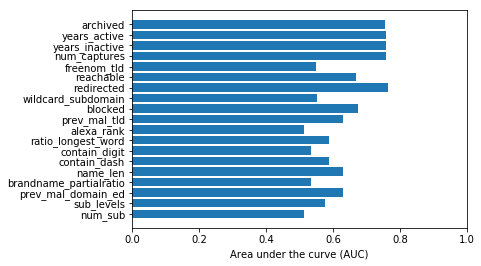

<Figure size 1080x720 with 0 Axes>

In [14]:
aucs = [x[0] for x in auc_feat_list]
feats = [x[1] for x in auc_feat_list]

fig, ax = plt.subplots()
plt.figure(figsize=(15,10))

# Example data
y_pos = np.arange(len(feats))

ax.barh(y_pos, aucs, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(feats)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Area under the curve (AUC)')
ax.set_xlim([0,1])
#ax.set_title('How fast do you want to go today?')

plt.show()

# Predict

In [36]:
#scaler = StandardScaler()
#scaler.fit(Xtrain_reduced)
#Xtrain_reduced = scaler.transform(Xtrain_reduced)
Xpredict = imp.transform(Xpredict)
Xpredict = scaler.transform(Xpredict)
print(Xpredict[:2])

[[-7.51293376e-01  4.66013494e-13 -2.35705341e-13  1.19004367e-14
  -3.59864218e-01 -4.11330863e-01 -3.88638774e-01 -9.28675952e-01
  -3.19660295e-14  4.06484970e-15  1.58602495e-12 -8.13681424e-01
   2.81712975e+00  2.44995766e+00  1.57472209e-01 -1.51748492e+00
  -4.17150777e-01 -4.66943080e-01  2.30772703e-02]
 [-7.51293376e-01  4.66013494e-13 -2.35705341e-13  1.19004367e-14
   2.77882587e+00 -4.11330863e-01 -3.88638774e-01 -9.28675952e-01
  -3.19660295e-14  4.06484970e-15  1.58602495e-12 -2.37379183e+00
   2.81712975e+00 -4.08170319e-01  1.57472209e-01 -1.92804029e+00
  -4.17150777e-01  5.21887634e+00 -4.20078769e-02]]


In [37]:
clf = classifiers[0]
name = names[0]
print(name)
clf.fit(Xtrain, ytrain)

Xpredict_pred = clf.predict(Xpredict)
Xpredict_proba = clf.predict_proba(Xpredict)
#print(sorted(Xpredict_proba[:,0]))

Neural Net


#### comp (deltaphish)

In [26]:
print("# 2nd level domains:", len(Xpredict_pred))
print("# compromised, hacked:", len([x for x in Xpredict_pred if x==1]))
print("# malicious, owned:", len([x for x in Xpredict_pred if x==0]))
print("% compromised, hacked:", len([x for x in Xpredict_pred if x==1])/len(Xpredict_pred))
print("% malicious, owned:", len([x for x in Xpredict_pred if x==0])/len(Xpredict_pred))

# 2nd level domains: 689
# compromised, hacked: 639
# malicious, owned: 50
% compromised, hacked: 0.9274310595065312
% malicious, owned: 0.07256894049346879


In [34]:
print("# 2nd level domains:", len(Xpredict_pred))
print("# compromised, hacked:", len([x for x in Xpredict_pred if x==1]))
print("# malicious, owned:", len([x for x in Xpredict_pred if x==0]))
print("% compromised, hacked:", len([x for x in Xpredict_pred if x==1])/len(Xpredict_pred))
print("% malicious, owned:", len([x for x in Xpredict_pred if x==0])/len(Xpredict_pred))

# 2nd level domains: 689
# compromised, hacked: 610
# malicious, owned: 79
% compromised, hacked: 0.8853410740203193
% malicious, owned: 0.11465892597968069


#### mal current (phishlabs)

In [18]:
print("# 2nd level domains:", len(Xpredict_pred))
print("# compromised, hacked:", len([x for x in Xpredict_pred if x==1]))
print("# malicious, owned:", len([x for x in Xpredict_pred if x==0]))
print("% compromised, hacked:", len([x for x in Xpredict_pred if x==1])/len(Xpredict_pred))
print("% malicious, owned:", len([x for x in Xpredict_pred if x==0])/len(Xpredict_pred))

# 2nd level domains: 2806
# compromised, hacked: 760
# malicious, owned: 2046
% compromised, hacked: 0.27084818246614395
% malicious, owned: 0.729151817533856


In [62]:
print("# 2nd level domains:", len(Xpredict_pred))
print("# compromised, hacked:", len([x for x in Xpredict_pred if x==1]))
print("# malicious, owned:", len([x for x in Xpredict_pred if x==0]))
print("% compromised, hacked:", len([x for x in Xpredict_pred if x==1])/len(Xpredict_pred))
print("% malicious, owned:", len([x for x in Xpredict_pred if x==0])/len(Xpredict_pred))

# 2nd level domains: 400
# compromised, hacked: 86
# malicious, owned: 314
% compromised, hacked: 0.215
% malicious, owned: 0.785


#### mal post (apwg)

In [22]:
print("# 2nd level domains:", len(Xpredict_pred))
print("# compromised, hacked:", len([x for x in Xpredict_pred if x==1]))
print("# malicious, owned:", len([x for x in Xpredict_pred if x==0]))
print("% compromised, hacked:", len([x for x in Xpredict_pred if x==1])/len(Xpredict_pred))
print("% malicious, owned:", len([x for x in Xpredict_pred if x==0])/len(Xpredict_pred))

# 2nd level domains: 324
# compromised, hacked: 68
# malicious, owned: 256
% compromised, hacked: 0.20987654320987653
% malicious, owned: 0.7901234567901234


In [30]:
print("# 2nd level domains:", len(Xpredict_pred))
print("# compromised, hacked:", len([x for x in Xpredict_pred if x==1]))
print("# malicious, owned:", len([x for x in Xpredict_pred if x==0]))
print("% compromised, hacked:", len([x for x in Xpredict_pred if x==1])/len(Xpredict_pred))
print("% malicious, owned:", len([x for x in Xpredict_pred if x==0])/len(Xpredict_pred))

# 2nd level domains: 324
# compromised, hacked: 69
# malicious, owned: 255
% compromised, hacked: 0.21296296296296297
% malicious, owned: 0.7870370370370371


# Model persistence

In [17]:
from joblib import dump, load
modelname = 'apwg'
filename = './model/'+modelname+'_scaler.joblib'
dump(scaler, filename)

['finalized_scaler.joblib']

In [21]:
filename = './model/'+modelname+'_imputer.joblib'
dump(imp, filename)

['finalized_imputer.joblib']

In [14]:
clf = classifiers[3]
clf.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [20]:
#from joblib import dump, load
filename = './model/'+modelname+'_model.joblib'
dump(clf, filename)
#pickle.dump(clf, 'mlp.joblib') 

['finalized_model.joblib']

# Xgboost

In [44]:
dtrain = xgb.DMatrix(Xtrain, label=ytrain)
dtest = xgb.DMatrix(Xtest, label=ytest)

In [45]:
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations

In [46]:
bst = xgb.train(param, dtrain, num_round)

In [47]:
bst.dump_model('dump.raw.txt')